In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-07-24 11:11:28.902815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 11:11:28.945229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 11:11:28.963689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 11:11:28.992250: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 11:11:31.801146: W tensorflow/compiler/tf2

In [15]:
DATASET = "mnist"
EMNIST_NUM_CLASSES = 10
EMNIST_IMAGE_SHAPE = (28, 28, 1)

In [3]:
# mnist corresponds to federated emnist(only_digits=True)
train_ds, val_ds = tfds.load('mnist', split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load('mnist', split='test')
len(train_ds), len(val_ds), len(test_ds)

(48000, 12000, 10000)

2024-07-24 11:13:41.040496: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<matplotlib.image.AxesImage at 0x1497814baef0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

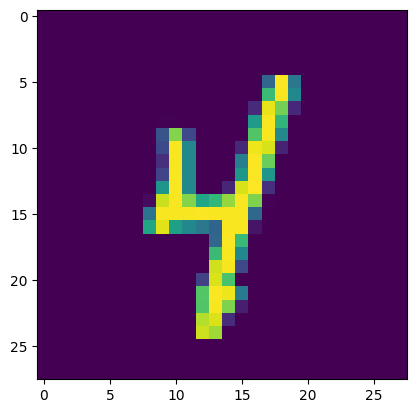

In [4]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [11]:
ex['image'].shape

TensorShape([28, 28, 1])

In [5]:
ex['image'].numpy().max()  # pixels should be scaled down between 0 and 1

255

In [34]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        # image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            .batch(64)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(8)
        )

In [35]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

## Models

In [36]:
from models import get_lucasnet, get_simple_cnn, get_mobilenet, get_efficientnet

In [37]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy on {DATASET}')
    plt.show()

### Simple Convolutional Model

In [42]:
model = get_simple_cnn(EMNIST_IMAGE_SHAPE, EMNIST_NUM_CLASSES)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6522 - loss: 1.0059 - val_accuracy: 0.9541 - val_loss: 0.1572
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9358 - loss: 0.2123 - val_accuracy: 0.9696 - val_loss: 0.1018
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9551 - loss: 0.1519 - val_accuracy: 0.9770 - val_loss: 0.0789
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9624 - loss: 0.1276 - val_accuracy: 0.9795 - val_loss: 0.0702
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9667 - loss: 0.1070 - val_accuracy: 0.9803 - val_loss: 0.0684
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9700 - loss: 0.0989 - val_accuracy: 0.9802 - val_loss: 0.0628
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9731 - loss: 0.0908 - val_accuracy: 0.9804 - val_loss: 0.0601
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9760 - loss: 0.0807 - val_accu

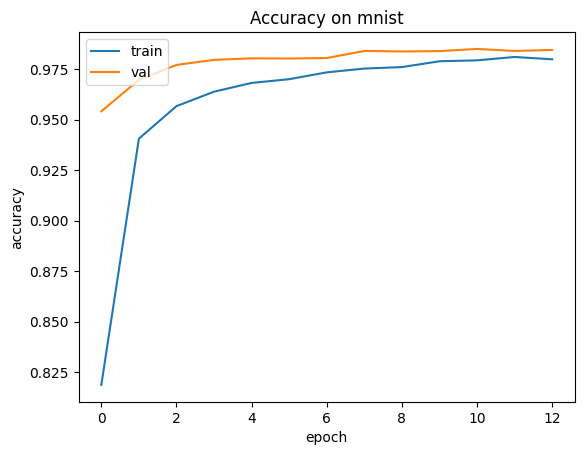

In [43]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)

### LL Architecture

In [40]:
model = get_lucasnet(EMNIST_IMAGE_SHAPE, EMNIST_NUM_CLASSES)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8620 - loss: 0.4362 - val_accuracy: 0.9792 - val_loss: 0.0694
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9778 - loss: 0.0767 - val_accuracy: 0.9858 - val_loss: 0.0472
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9841 - loss: 0.0519 - val_accuracy: 0.9877 - val_loss: 0.0405
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9886 - loss: 0.0391 - val_accuracy: 0.9887 - val_loss: 0.0382
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9908 - loss: 0.0293 - val_accuracy: 0.9901 - val_loss: 0.0351
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9920 - loss: 0.0247 - val_accuracy: 0.9893 - val_loss: 0.0346
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9948 - loss: 0.0186 - val_accuracy: 0.9909 - val_loss: 0.0281
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9964 - loss: 0.0142 - val

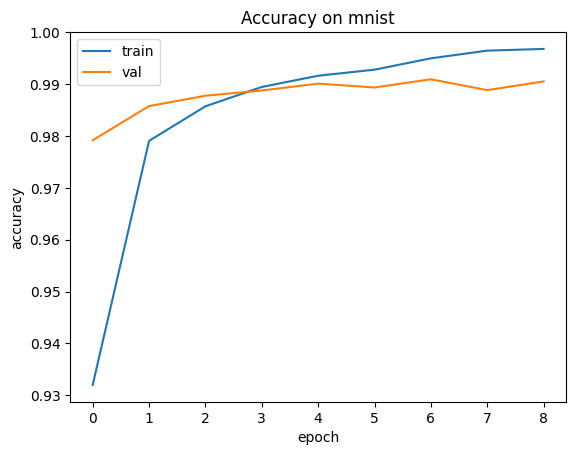

In [41]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)

### MobileNet

MobileNet doesn't work with the Grayscale shape

### EfficientNet

I didn't see the need to use it as it creates a lot of overhead